<a href="https://colab.research.google.com/github/MartinaJoergensen/FirstCodes/blob/master/Copy_of_GNN_Tutorial_Pierini_PyG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN Tutorial (PyG) — Exercise

Dataset citation:

https://chrsmrrs.github.io/datasets/docs/home/
Riesen, K. and Bunke, H.: IAM Graph Database Repository for Graph Based Pattern Recognition and Machine Learning. In: da Vitora Lobo, N. et al. (Eds.), SSPR&SPR 2008, LNCS, vol. 5342, pp. 287-297, 2008.

AIDS Antiviral Screen Data (2004)


## Imports

In [1]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 947.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00


In [2]:
import os
import pickle
from typing import List

import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

print('PyTorch:', torch.__version__)
print('PyG:', torch_geometric.__version__)


PyTorch: 2.8.0+cu126
PyG: 2.7.0


## NetworkX Star Graph (warm-up)

Exercise: create a star graph with 1 center and 3 leaves, and plot it with labels.
Hint: you can use `nx.star_graph(n)` or add nodes and edges manually (DiGraph).


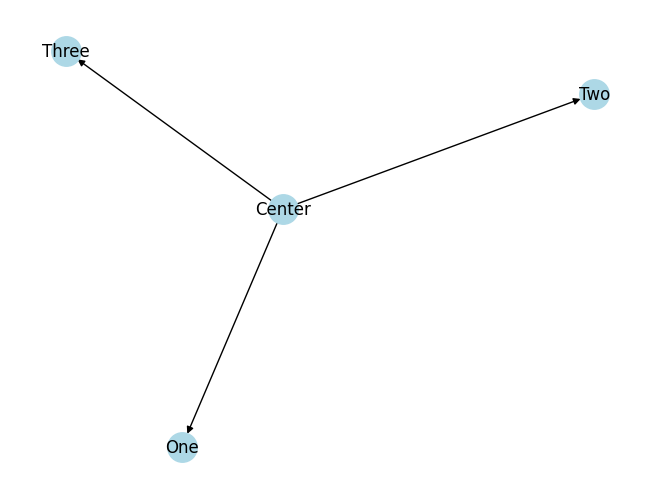

In [3]:
# TODO: Create and plot a directed star graph with 1 center and 3 leaves
# and then plot it.

G_star = nx.DiGraph()
G_star.add_node('Center')
G_star.add_node('One')
G_star.add_node('Two')
G_star.add_node('Three')

G_star.add_edge('Center', 'One')
G_star.add_edge('Center', 'Two')
G_star.add_edge('Center', 'Three')

nx.draw(G_star, with_labels=True, arrows=True, node_color='lightblue', node_size=450)


#raise RuntimeError('Checkpoint - Star Graph')


## Download dataset (if missing)

In [4]:
# Colab/Local: fetch graph_db.bin from Google Drive if not present
if not os.path.exists('graph_db.bin'):
    print('Downloading graph_db.bin ...')
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ' -O graph_db.bin
else:
    print('graph_db.bin found, skipping download.')


--2025-10-21 12:46:19--  https://docs.google.com/uc?export=download&id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ
Resolving docs.google.com (docs.google.com)... 74.125.196.139, 74.125.196.100, 74.125.196.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.196.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ&export=download [following]
--2025-10-21 12:46:19--  https://drive.usercontent.google.com/download?id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.210.132, 2607:f8b0:400c:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.210.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2847517 (2.7M) [application/octet-stream]
Saving to: ‘graph_db.bin’

graph_db.bin        100%[===================>]   2.71M  12.5MB/s    i

## Utils: one-hot and conversion NetworkX -> PyG Data

In [5]:
def to_one_hot(label: int, num_classes: int):
    vec = np.zeros(num_classes, dtype=np.float32)
    vec[int(label)] = 1.0
    return vec.tolist()

def _as_class_index(val, num_classes):
    arr = np.asarray(val)
    if arr.ndim == 0:
        return int(arr)
    arr = arr.reshape(-1)
    if arr.size == 1:
        return int(arr[0])
    return int(np.argmax(arr))

def convert_nx_to_pyg_data(G: nx.Graph, num_node_label_classes: int = 38, num_edge_label_classes: int = 3) -> Data:
    node_ids_sorted = sorted(list(G.nodes()))
    nid_to_idx = {nid: i for i, nid in enumerate(node_ids_sorted)}
    node_features = []
    for nid in node_ids_sorted:
        attrs = np.asarray(G.nodes[nid]['attributes'], dtype=np.float32).tolist()
        nlab = _as_class_index(G.nodes[nid]['labels'], num_node_label_classes)
        feat = np.asarray(list(attrs) + to_one_hot(nlab, num_node_label_classes), dtype=np.float32)
        node_features.append(feat)
    x = torch.tensor(np.stack(node_features, axis=0), dtype=torch.float32)
    src, dst, eattr = [], [], []
    for (u, v) in G.edges():
        elab_raw = G.edges[(u, v)]['labels']
        arr = np.asarray(elab_raw).reshape(-1)
        if arr.size == num_edge_label_classes:
            one = arr.astype(np.float32)
        else:
            one = np.asarray(to_one_hot(_as_class_index(elab_raw, num_edge_label_classes), num_edge_label_classes), dtype=np.float32)
        ui = nid_to_idx[u]; vi = nid_to_idx[v]
        src += [ui, vi]; dst += [vi, ui]; eattr += [one, one]
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr = torch.tensor(np.stack(eattr, axis=0), dtype=torch.float32)
    y_scalar = float(_as_class_index(G.graph.get('classes', 0), 2))
    y = torch.tensor([y_scalar], dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


## Load and preprocess data

In [6]:
def load_graphs_pickle(path: str, limit: int = -1) -> List[nx.Graph]:
    db = pickle.load(open(path, 'rb'))
    if limit is not None and limit > 0:
        db = db[:limit]
    return db

def nx_list_to_pyg(db: List[nx.Graph]) -> List[Data]:
    return [convert_nx_to_pyg_data(G) for G in tqdm(db, desc='Converting to PyG')]

graphs_nx = load_graphs_pickle('graph_db.bin', limit=-1)
data_list = nx_list_to_pyg(graphs_nx)
len(data_list), data_list[0]


Converting to PyG: 100%|██████████| 2000/2000 [00:04<00:00, 422.85it/s]


(2000, Data(x=[47, 42], edge_index=[2, 106], edge_attr=[106, 3], y=[1]))

### Plot two samples with NetworkX (active vs inactive)

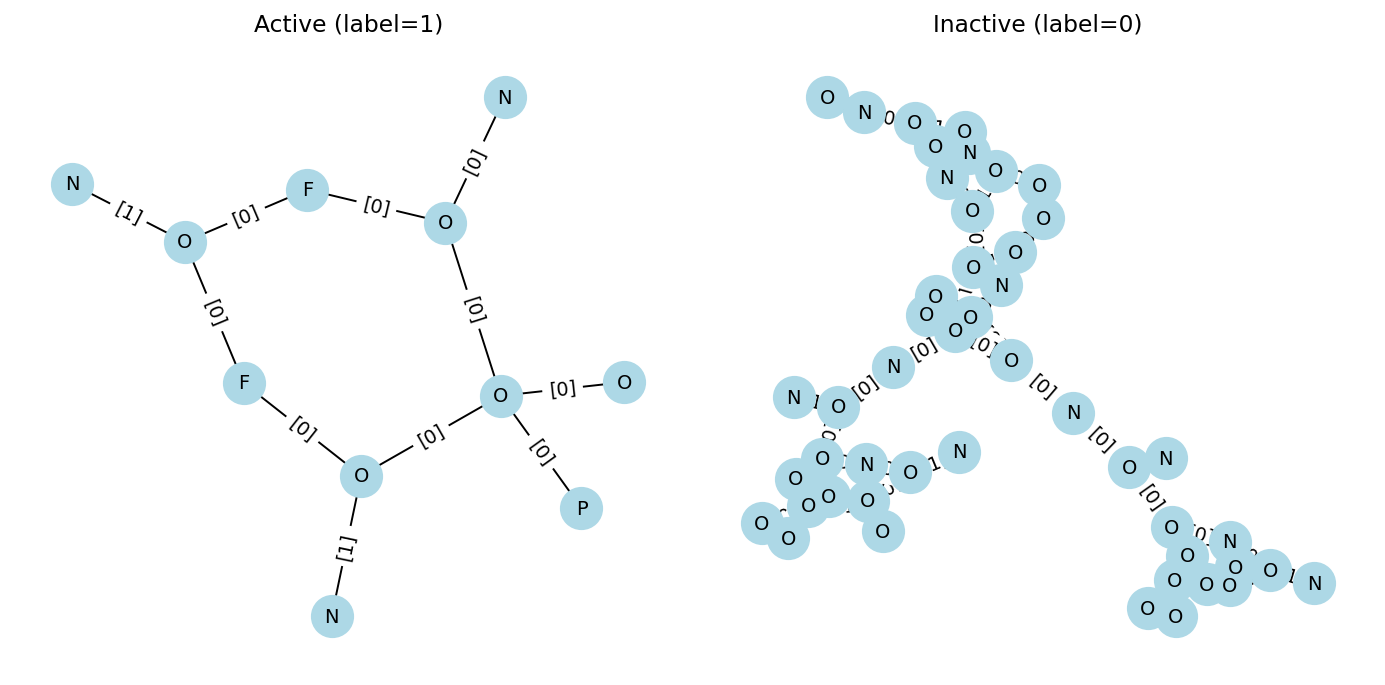

In [7]:
import matplotlib.pyplot as plt

def plot_networkx_graph(G: nx.Graph, ax=None, title: str = 'Molecule'):
    numeric_to_str_atomic_codes = { 0: 'C',1: 'O',2: 'N',3: 'Cl',4: 'F',5: 'S',6: 'Se',7: 'P',8: 'Na',9: 'I',
                                    10: 'Co',11: 'Br',12: 'Li',13: 'Si',14: 'Mg',15: 'Cu',16: 'As',17: 'B',
                                    18: 'Pt',19: 'Ru',20: 'K',21: 'Pd',22: 'Au',23: 'Te',24: 'W',25: 'Rh',26: 'Zn',
                                    27: 'Bi',28: 'Pb',29: 'Ge',30: 'Sb',31: 'Sn',32: 'Ga',33: 'Hg',34: 'Ho',35: 'Tl',
                                    36: 'Ni',37: 'Tb'}
    if ax is None:
        ax = plt.gca()
    pos = nx.spring_layout(G, seed=0)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=450, ax=ax)
    attrs = nx.get_node_attributes(G, 'attributes')
    if attrs:
        node_label_atom = {k: numeric_to_str_atomic_codes.get(int(v[0]), str(int(v[0]))) for k, v in attrs.items()}
        nx.draw_networkx_labels(G, pos, labels=node_label_atom, font_size=10, ax=ax)
    elabs = nx.get_edge_attributes(G, 'labels')
    if elabs:
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(i,j): str(elabs[(i,j)]) for (i,j) in G.edges()}, ax=ax)
    ax.set_title(title)
    ax.axis('off')

# Helper to get binary class from graph meta (supports int or one-hot)
import numpy as _np

def get_label(G: nx.Graph) -> int:
    y = G.graph.get('classes', 0)
    arr = _np.asarray(y)
    if arr.ndim == 0:
        return int(arr)
    arr = arr.reshape(-1)
    if arr.size == 1:
        return int(arr[0])
    return int(arr.argmax())

# Pick one active (1) and one inactive (0) molecule
active = next((g for g in graphs_nx if get_label(g) == 1), graphs_nx[0])
inactive = next((g for g in graphs_nx if get_label(g) == 0), graphs_nx[-1])

# Plot side-by-side using subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=140)
plot_networkx_graph(active, ax=axs[0], title='Active (label=1)')
plot_networkx_graph(inactive, ax=axs[1], title='Inactive (label=0)')
plt.tight_layout()
plt.show()


## Train/Val/Test split

In [8]:
def split_data(data_list: List[Data], seed: int = 42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(data_list))
    rng.shuffle(idx)
    n = len(idx)
    n_val = int(0.2 * n); n_test = int(0.2 * n)
    val_idx = idx[:n_val]; test_idx = idx[n_val:n_val + n_test]; train_idx = idx[n_val + n_test:]
    take = lambda ids: [data_list[i] for i in ids]
    return take(train_idx), take(val_idx), take(test_idx)

train_data, val_data, test_data = split_data(data_list, seed=42)
len(train_data), len(val_data), len(test_data)


(1200, 400, 400)

## DataLoaders

In [9]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
len(train_loader), len(val_loader), len(test_loader)


(38, 13, 13)

## PyTorch Primer: Simple CNN
A compact CNN example to illustrate core PyTorch patterns (modules, forward, tensors).

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 10):
        super().__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
        ])
        self.pool = nn.MaxPool2d(2, 2)

        self.head = nn.Linear(32, num_classes) #dense layer then you apply the nonlinearity

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        print("Shape", x.shape)
        for conv in self.convs:
            x = F.relu(conv(x))
            x = self.pool(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        logits = self.head(x)
        return logits

# Example forward pass on dummy data (MNIST-like)
cnn = SimpleCNN(in_channels=1, num_classes=10)
demo_x = torch.randn(4, 1, 28, 28)
demo_logits = cnn(demo_x)
print('Output shape:', demo_logits.shape)

#raise RuntimeError('Checkpoint - Simple CNN')


Output shape: torch.Size([4, 10])


## Model (MPNN-style)
We now implement a message passing layer and a small GNN.
PyG `Data` packs graph tensors: `x` (node features), `edge_index` (2×E indices), `edge_attr` (edge features), and `batch` (graph id per node).
The line `x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch` unpacks those for convenience.

In [11]:
class MPNNLayer(MessagePassing):
    """
    A single message passing layer following the MPNN formalism:
      - message:   m_v = sum_{w in N(v)} M_t(h_w, h_v, e_{wv})
      - update:    h_v' = U_t(h_v, m_v)

    Where h_v, h_w are node states and e_{wv} is the edge feature.

    Your task: implement message() and update() with small MLPs or linear+nonlinearity.
    Tip: you will likely concatenate tensors along the last dim.
    Shapes (per edge or node, at runtime):
      h_v: [hidden], h_w: [hidden], e_{wv}: [edge_dim]
    """
    def __init__(self, hidden: int, edge_dim: int, dropout: float = 0.0, aggr: str = 'add'):
        super().__init__(aggr=aggr)
        self.dropout = dropout
        # Example layer you might create:
        # self.m1 = nn.Linear(hidden + edge_dim + hidden, hidden)
        # Note: In PyTorch, activations are separate — call F.relu(tensor) explicitly
        # between Linear layers (or use nn.ReLU modules).

        self.m1 = nn.Linear(hidden + edge_dim + hidden, hidden)
        self.m2 = nn.Linear(hidden, hidden)

        self.u1 = nn.Linear(hidden + hidden, hidden)
        self.u2 = nn.Linear(hidden, hidden)


    def forward(self, h: torch.Tensor, edge_index: Adj, e_wv: torch.Tensor):
        """
        h: node states (a.k.a. x)
        edge_index: [2, E] directed edges (source->target indices)
        e_wv: edge features per edge
        """
        return self.propagate(edge_index, h=h, e_wv=e_wv)

    def message(self, h_i: torch.Tensor, h_j: torch.Tensor, e_wv: torch.Tensor) -> torch.Tensor:
        """
        Message function M_t(h_w, h_v, e_{wv}) computed on each edge (w->v):
        - h_j corresponds to h_w (source node on edge)
        - h_i corresponds to h_v (target node on edge)
        - edge_attr corresponds to e_{wv}
        Return one message vector per edge with shape [hidden].

        Note: Concatenate tensors with torch.cat([t1, t2, t3], dim=-1).
        """

        # Aliases to match the notation we studied in the last lecture
        h_w = h_j
        h_v = h_i

        x = torch.cat([h_w,h_v, e_wv], dim=-1)
        x = F.relu(self.m1(x))
        x = F.relu(self.m2(x))


       # m = x used for convention with lectures
        return x

    def update(self, aggr_out: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        """
        Update function U_t(h_v, m_v) computed on each node v after messages are aggregated:
        - aggr_out is the aggregated message m_v (sum/mean over incoming edges)
        - x is the previous node state h_v
        Return new node state h_v' with shape [hidden].
        """
        # Aliases to match the notation from the paper
        m_v = aggr_out
        h_v = h

        x = torch.cat([m_v, h_v], dim=-1)
        x = F.relu(self.u1(x))
        x = F.relu(self.u2(x))


         # TODO: implement update U([h_v=h, m_v=aggr_out])
        return x

class GNN(nn.Module):
    """
    Build a full graph network using several MPNNLayer blocks.
    Outline:
      - Project input node features (in_dim) to hidden via a Linear layer.
      - Stack k MPNNLayer blocks (ModuleList) and apply non-linearities/dropout between them.
      - Pool node embeddings to a single graph embedding using a permutation-invariant readout.
        global_mean_pool averages node embeddings per graph id — useful for graph-level tasks.
      - Use a small head to produce a single logit per graph.
    """
    def __init__(self):
        super().__init__()
        self.dropout = 0.5
        self.edge_dim = 3
        self.input_node_dim = 42
        self.lin_in = nn.Linear(self.input_node_dim, 64)
        # TODO: build the full GNN:
        #  - create a stack of MPNNLayer: self.layers = nn.ModuleList([MPNNLayer(64, 3, dropout=0.5) for _ in range(3)])
        #  - define a small readout head: e.g., self.out1 = nn.Linear(64, 64); self.out2 = nn.Linear(64, 1)

        self.out1 = nn.Linear(64, 64)
        self.out2 = nn.Linear(64, 1)

        self.gnn_layers = nn.ModuleList([MPNNLayer(64, 3, dropout=0.5) for _ in range(3)])

    def forward(self, data: Data):
        # PyG Data packs graph tensors (batched):
        #  x: [total_nodes, in_dim]          node features
        #  edge_index: [2, E]                 source/target indices for each edge
        #  edge_attr: [E, edge_dim]           edge (bond) features
        #  batch: [total_nodes]               graph id for each node (to pool by graph)
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # 1) Input projection to hidden dim
        x = self.lin_in(x)

        # 2) Message passing stack
        #x = None  # TODO: iterate your MPNNLayer stack over (x, edge_index, edge_attr); add ReLU/Dropout between layers

        for gnn_layer in self.gnn_layers:
          x = gnn_layer(x, edge_index,edge_attr)



        # 3) Graph readout:
        # global_mean_pool(x, batch) aggregates node embeddings into one vector per graph by averaging.
        # After pooling, add a small MLP/Linear head to get a single logit per graph.

        x = global_mean_pool(x, batch)
        x = F.relu(self.out1(x))
        x = self.out2(x)

        x = x[:,0] #[batch size, 1 => [Batch, size]

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
model

#raise RuntimeError('Checkpoint - Build the GNN (implement message/update, layer stack, pooling, and head)')


GNN(
  (lin_in): Linear(in_features=42, out_features=64, bias=True)
  (out1): Linear(in_features=64, out_features=64, bias=True)
  (out2): Linear(in_features=64, out_features=1, bias=True)
  (gnn_layers): ModuleList(
    (0-2): 3 x MPNNLayer()
  )
)

In [12]:
def bce_logits_loss():
    return nn.BCEWithLogitsLoss()

# Standard training epoch
def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss, total_acc, total_count = 0.0, 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad()
        logits = model(batch)  # [B]
        y = batch.y.view(-1).to(device)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        # metrics
        with torch.no_grad():
            preds = (logits.sigmoid() > 0.5).float()
            yb = y.view_as(preds)
            acc = (preds == yb).float().mean().item()
        total_loss += loss.item() * y.size(0)
        total_acc += acc * y.size(0)
        total_count += y.size(0)
    return total_loss / max(total_count, 1), total_acc / max(total_count, 1)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, total_count = 0.0, 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        y = batch.y.view(-1).to(device)
        loss = criterion(logits, y)
        preds = (logits.sigmoid() > 0.5).float()
        yb = y.view_as(preds)
        acc = (preds == yb).float().mean().item()
        total_loss += loss.item() * y.size(0)
        total_acc += acc * y.size(0)
        total_count += y.size(0)
    return total_loss / max(total_count, 1), total_acc / max(total_count, 1)

# Training config (run after you finish the GNN implementation)
epochs = 20
lr = 1e-4
criterion = bce_logits_loss()
optimizer = Adam(model.parameters(), lr=lr)

# Track metrics for plotting
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(model, val_loader, criterion)
    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)
    print(f'Epoch {ep:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}')


Epoch 01 | train loss 0.7166 acc 0.196 | val loss 0.7059 acc 0.228
Epoch 02 | train loss 0.6967 acc 0.392 | val loss 0.6832 acc 0.772
Epoch 03 | train loss 0.6412 acc 0.804 | val loss 0.5846 acc 0.772
Epoch 04 | train loss 0.4765 acc 0.804 | val loss 0.4323 acc 0.772
Epoch 05 | train loss 0.3658 acc 0.827 | val loss 0.3814 acc 0.838
Epoch 06 | train loss 0.3267 acc 0.889 | val loss 0.3215 acc 0.890
Epoch 07 | train loss 0.2616 acc 0.915 | val loss 0.2811 acc 0.905
Epoch 08 | train loss 0.2032 acc 0.929 | val loss 0.1953 acc 0.943
Epoch 09 | train loss 0.1746 acc 0.937 | val loss 0.1528 acc 0.958
Epoch 10 | train loss 0.1510 acc 0.946 | val loss 0.1248 acc 0.965
Epoch 11 | train loss 0.1103 acc 0.968 | val loss 0.1061 acc 0.973
Epoch 12 | train loss 0.0894 acc 0.977 | val loss 0.0841 acc 0.980
Epoch 13 | train loss 0.0889 acc 0.974 | val loss 0.0761 acc 0.985
Epoch 14 | train loss 0.0694 acc 0.983 | val loss 0.0881 acc 0.975
Epoch 15 | train loss 0.0724 acc 0.982 | val loss 0.0690 acc 0

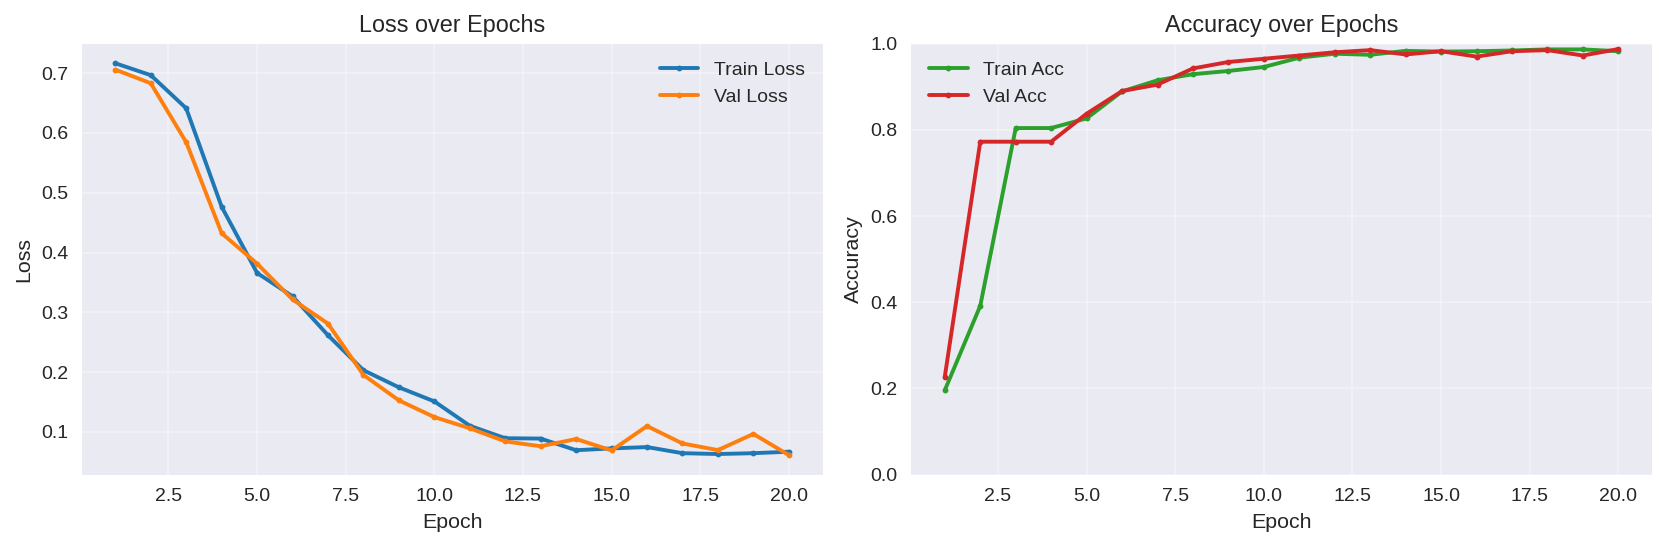

In [13]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=140)
epochs_range = range(1, epochs + 1)
# Loss
axs[0].plot(epochs_range, history['train_loss'], label='Train Loss', color='#1f77b4', marker='o', linewidth=2, markersize=3)
axs[0].plot(epochs_range, history['val_loss'], label='Val Loss', color='#ff7f0e', marker='o', linewidth=2, markersize=3)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Epochs')
axs[0].grid(True, alpha=0.3)
axs[0].legend(frameon=False)
# Accuracy
axs[1].plot(epochs_range, history['train_acc'], label='Train Acc', color='#2ca02c', marker='o', linewidth=2, markersize=3)
axs[1].plot(epochs_range, history['val_acc'], label='Val Acc', color='#d62728', marker='o', linewidth=2, markersize=3)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0.0, 1.0)
axs[1].set_title('Accuracy over Epochs')
axs[1].grid(True, alpha=0.3)
axs[1].legend(frameon=False)
plt.tight_layout()
plt.show()

In [14]:
te_loss, te_acc = evaluate(model, test_loader, criterion)
print(f'Test loss {te_loss:.4f} acc {te_acc:.3f}')


Test loss 0.0533 acc 0.993


## Lecture
https://drive.google.com/drive/folders/1sBIx19EuHKTkuLEu5iv1DWOPa3Zvtn3c?usp=share_link




 from what I understand after Chatgpt:

m1 and m2 process the raw inputs on each edge to create messages.
These messages are aggregated per node (like summed up).
Then, u1 takes this aggregated message combined with the old node feature and processes it.
u2 takes the output of u1 and further refines it to produce the final updated node feature.

About the message passing:

Message passing means each node communicates with its neighbors by sending messages along edges:

*  For every neighbor node w of node v, you compute a message using m1 and m2 based on:


1.   The neighbor’s features h_w
2.   The current node’s features h_v
3.   The edge features e_wv connecting them

* Then all these messages from all neighbors are aggregated (usually summed or averaged) at node v.

* Finally, node v updates its own features based on this aggregated message and its current features, using u1 and u2.
